# Restaurant Simulation

#### Emily Clements and Usa (Mabelle) Wongsanguan

CBE 40455: Final Project  
December 14, 2017

## Introduction

This simulation is based on the simulation of Spanky's Pizzeria.

REST is a sit down restaurant, where groups can come in, sit down and choose food from the menu. 

Some options on the menu are more popular than others, and they all take different amounts of time to prepare and cook. Depending on the day, there are different numbers of servers and cooks. The number of ovens and tables that are currently in use can vary as well. 

The servers estimate wait times based on the type of food that is ordered, and the staff tries to get the orders complete as quickly as they can, given the amount of customers who are present. 

The number of late orders, as well as the degree of lateness, is graphed, so that the business of the restaurant can be modelled. A simulation is also done investigating how adding cooks, servers, tables or ovens would change the numbers of orders that could be complete, and minimizing the late time. 

In [1]:
# import the necessary libraries 

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import simpy
import itertools
import random
import pandas as pd
import numpy as np

### Menu


In [2]:
# the menu has the food choices, as well as their poopularity (the probability that someone will order them)
# it also has their cook and prep times 
menu = {
    'Pizza': {'Popularity': 0.4, 'prep time': 0, 'cook time': 13},
    'Pasta': {'Popularity': 0.3, 'prep time': 1, 'cook time': 10},
    'Veggie Burger': {'Popularity': 0.2, 'prep time': 1, 'cook time': 10},
    'Falafel': {'Popularity': 0.1, 'prep time': 0, 'cook time': 8}
}

# GroupSize shows the probability of a group being a certain size (eg 0% for size 0, 5% for 1, 40% for 2 people)
GroupSize = [0, 0.05, .4, .1, .35, .1]

#puts the menu into a dataframe
menu = pd.DataFrame(menu)

items = menu.columns
popu = menu.loc['Popularity',:]

# prints the menu
menu

,Falafel,Pasta,Pizza,Veggie Burger
Popularity,0.1,0.3,0.4,0.2
cook time,8.0,10.0,13.0,10.0
prep time,0.0,1.0,0.0,1.0


### Creating the simulation 

In [3]:
class Rest(object):

    def __init__(self,N_SERVERS=1,N_COOKS=2, N_OVENS=3, N_TABLES=10, T_ORDER=10):
        self.env = simpy.Environment()
        self.server = simpy.Resource(self.env,N_SERVERS)   # server resources
        self.cook = simpy.Resource(self.env,N_COOKS)       # cook resources 
        self.oven = simpy.Resource(self.env,N_OVENS)       # oven resources
        self.table = simpy.Resource(self.env, N_TABLES)    # table resources
        self.T_ORDER = T_ORDER                             # initializes variables  
        self.orderId = 0
        self.GROUP = 0
        self.data = dict()
        self.orderQueue = pd.Series([0],[0])               # track orders in progress
        self.env.process(self.orderGenerator())            # where to start the model
        
    def orderGenerator(self):
        for orderId in itertools.count():
            self.orderId=orderId  
            yield self.env.timeout(random.expovariate(1.0/self.T_ORDER)) # random amount of time between groups based on T_ORDER
            self.GROUP= np.random.choice (len(GroupSize), p=GroupSize) # The GroupSize is determined based on their probabilities
            self.env.process(self.waittable()) # sends the model to the next function (waittable)
    
    def waittable(self):
        with self.table.request() as tablereq:
            yield tablereq # waits for a table to be available
            with self.server.request() as serverreq:
                yield serverreq # waits for a server to seat the customers
                yield self.env.timeout(random.random()) # time to see customer/give the menu (random based on customer chattiness)
                grouporder = [] #initializes the array
                torder = 0
                sizegroup=[] #initializes the array
                for i in range (0,self.GROUP):
                    sizegroup.append(i) #makes an array of the people in the group
                for g in sizegroup:
                    food=np.random.choice(items,p = popu) #people pick what they want to order based on populartity 
                    grouporder.append(food) # a group order is created
                    torder=max(torder, menu[food]['prep time'] + menu[food]['cook time']) # the max time for the order is quoted
                    self.writeLog(self.orderId,food,'0 arrival') # notes it in the log
                    self.env.process(self.order(self.orderId,food)) # sends the model to the next function (order)

    def order(self,orderId,food):
        # take order from customer
        with self.server.request() as serverreq:
            yield serverreq # waits for a server to take the order
            self.writeLog(orderId,food,'1 order') # notes it in the log
            self.writeOrderQueue(+1) # notes it in the log
            yield self.env.timeout(0.5) # times out while the server takes the order
            # give receipt to customer
            self.writeLog(orderId,food,'2 receipt') # notes it in the log
            # quote finish time to customer
            tquote = self.env.now + menu[food]['prep time'] + menu[food]['cook time'] + 1 # approximates how long the order will take to complete
            self.writeLog(orderId,food,'6 tquote',tquote) # notes it in the log

        # request cook to prep order
        with self.cook.request() as cookreq:
            yield cookreq # waits for a cook to be prepared to cook the food
            self.writeLog(orderId,food,'3 prep') # notes it in the log
            yield self.env.timeout(menu[food]['prep time']) # waits as the cook prepares the food

        # request oven to cook order
        with self.oven.request() as ovenreq:
            yield ovenreq # waits for an oven 
            # request cook to load oven
            with self.cook.request() as cookreq:
                yield cookreq # waits for a cook to load the oven 
                yield self.env.timeout(0.25) # time it takes to load the oven 
                self.writeLog(orderId,food,'4 oven') # notes it in the log
            # cook order
            yield self.env.timeout(menu[food]['cook time'])
            # request cook to unload oven
            with self.cook.request() as cookreq:
                yield cookreq # waits for a cook to unload the oven 
                yield self.env.timeout(0.25)
                self.writeLog(orderId,food,'5 finish') # notes it in the log
                self.writeOrderQueue(-1) # notes it in the log
      #  yield self.env.timeout(15) # time out while the customers eat their food before releasing the table 

    def writeLog(self,orderId,food,event,t=None):
        if t==None:
            t = self.env.now # sets the time
        self.data[orderId,food,event] = t
        
    @property
    def log(self):
        df = pd.DataFrame([[a,b,c,self.data[a,b,c]] for (a,b,c) in self.data.keys()])
        df.columns = ['OrderID','Item','Event','Time']
        return df.pivot_table(values='Time',index=['OrderID','Item'],columns=['Event'])
    
    def stats(self):
        df = w.log
        late = df['5 finish']-df['6 tquote'] #determines if it took longer for the order to arrive than was quoted
        late = late[late > 0] # The ones that took longer are 'late'
        
        N = {}
        N['orders'] = df[df['1 order']>0]['1 order'].count() # notes the number of orders
        N['finished'] = df[df['5 finish']>0]['5 finish'].count() # notes the number of finished orders
        N['late'] = late.count() # notes the number of late orders
        N['latefrac'] = N['late']/N['orders'] # notes the fraction of late orders
        N['meanlate'] = late.mean() # notes the average lateness of orders
        N['maxlate'] = late.max() # notes the maximum lateness of orders
        
        #prints the orders recieved, finished, late, the percent of late orgers, the average lateness and the maximum lateness
        print(" Orders Received = {0:6d}".format(N['orders']))
        print(" Orders Finished = {0:6d}".format(N['finished']))
        print("     Late Orders = {0:6d}".format(N['late']))
        print("   Fraction late = {0:6.3f}".format(N['latefrac']))
        print("Average lateness = {0:6.3f}".format(N['meanlate']))
        print("Maximum lateness = {0:6.3f}".format(N['maxlate']))
        
        # plot the results 
        plt.subplot(2,1,1)
        late.hist()
        plt.title('Distribution of Late Orders')
        plt.ylabel('Number of orders')
        plt.xlabel('Minutes late')
        plt.subplot(2,1,2)
        w.orderQueue.plot()
        plt.xlabel('Time [min]')
        plt.ylabel('Orders')
        plt.title('Orders in Process')
        plt.tight_layout()

        return N

    def writeOrderQueue(self,inc):                         # track orders in progress
        self.orderQueue[self.env.now] = self.orderQueue.iloc[-1] + inc
                    
    def run(self,t_sim): # runs the simulation for the given amount of time 
        self.env.run(until=t_sim)

### Run the Simulation 

 Orders Received =     25
 Orders Finished =     18
     Late Orders =     18
   Fraction late =  0.720
Average lateness = 51.920
Maximum lateness = 76.312


{'finished': 18,
 'late': 18,
 'latefrac': 0.71999999999999997,
 'maxlate': 76.311959779510573,
 'meanlate': 51.91964375966919,
 'orders': 25}

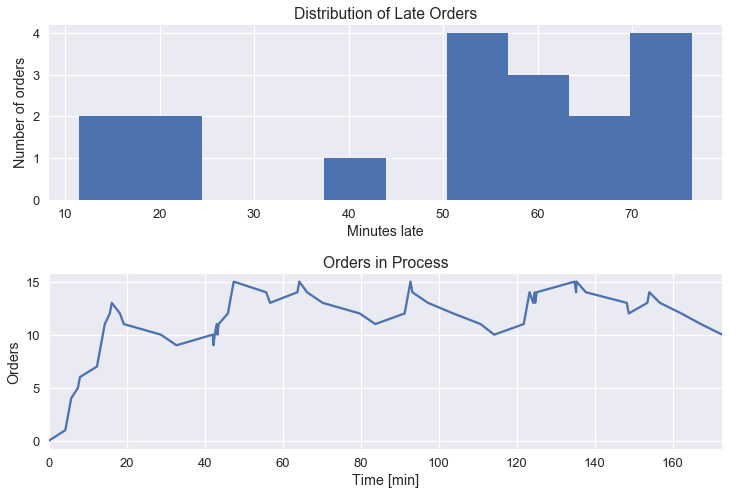

In [4]:

# create simulation with one server, two ovens, two cooks, with orders arriving at an average of 10 minutes
w = Rest(1,2, 2, 10)

# run a simulation for 180 minutes
w.run(180)

# summarize data
w.stats()

### How does adding more servers/cooks/ovens/tables change the statitics?

 Orders Received =     42
 Orders Finished =     27
     Late Orders =     24
   Fraction late =  0.571
Average lateness = 16.549
Maximum lateness = 36.690


{'finished': 27,
 'late': 24,
 'latefrac': 0.5714285714285714,
 'maxlate': 36.690374126619588,
 'meanlate': 16.548659305391663,
 'orders': 42}

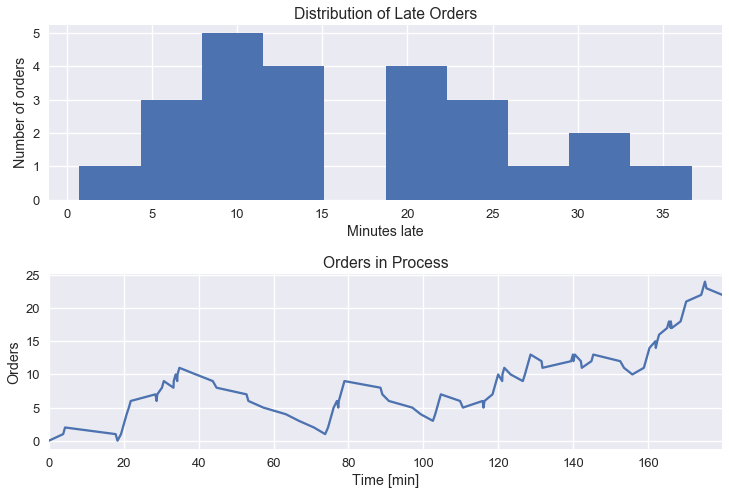

In [5]:
# create simulation with one server, two ovens, three cooks, ten tables, with orders arriving at an average of 10 minutes
w = Rest(1,2, 3, 10, 10)

# run a simulation for 180 minutes
w.run(180)

# summarize data
w.stats()

 Orders Received =     41
 Orders Finished =     24
     Late Orders =     23
   Fraction late =  0.561
Average lateness = 69.841
Maximum lateness = 116.416


{'finished': 24,
 'late': 23,
 'latefrac': 0.56097560975609762,
 'maxlate': 116.41611191342068,
 'meanlate': 69.84128078067855,
 'orders': 41}

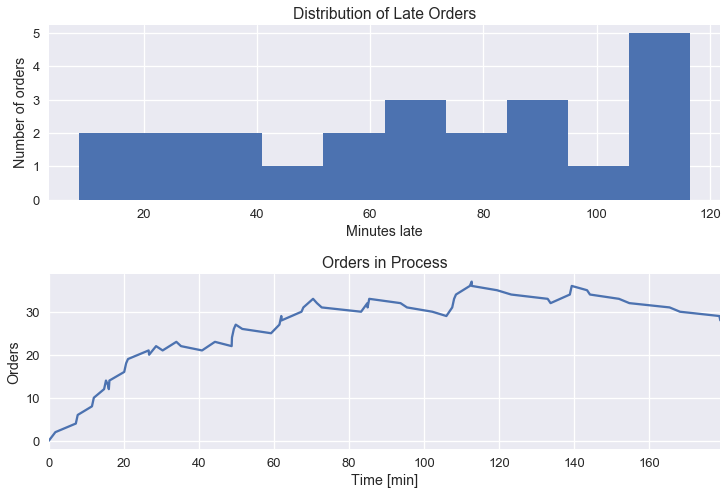

In [6]:
# create simulation with two servers, two ovens, two cooks, ten tables, with orders arriving at an average of 10 minutes
w = Rest(2,2, 2, 10, 10)

# run a simulation for 180 minutes
w.run(180)

# summarize data
w.stats()

 Orders Received =     30
 Orders Finished =     13
     Late Orders =     10
   Fraction late =  0.333
Average lateness = 30.556
Maximum lateness = 71.324


{'finished': 13,
 'late': 10,
 'latefrac': 0.33333333333333331,
 'maxlate': 71.324146023067826,
 'meanlate': 30.556208321569205,
 'orders': 30}

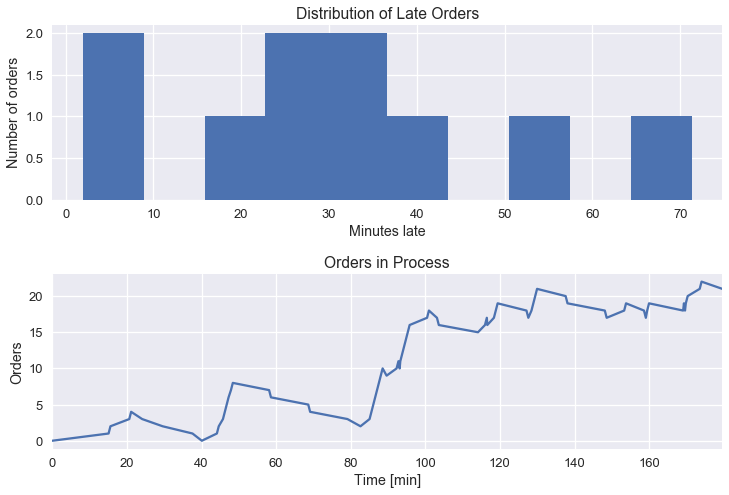

In [7]:
# create simulation with one server, three ovens, two cooks, ten tables, with orders arriving at an average of 10 minutes
w = Rest(1,3, 2, 10, 10)

# run a simulation for 180 minutes
w.run(180)

# summarize data
w.stats()

 Orders Received =     48
 Orders Finished =     19
     Late Orders =     16
   Fraction late =  0.333
Average lateness = 36.818
Maximum lateness = 72.202


{'finished': 19,
 'late': 16,
 'latefrac': 0.33333333333333331,
 'maxlate': 72.202140399861321,
 'meanlate': 36.81753424663344,
 'orders': 48}

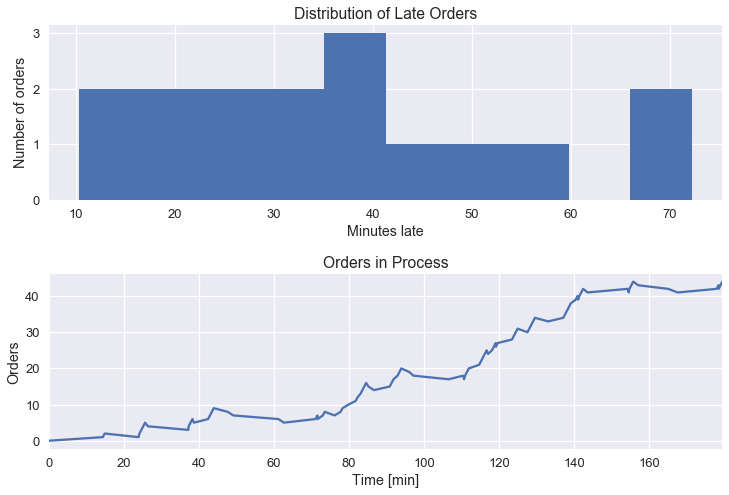

In [8]:
# create simulation with one server, two ovens, two cooks, fifteen tables, with orders arriving at an average of 10 minutes
w = Rest(1,2, 2, 15, 10)

# run a simulation for 180 minutes
w.run(180)

# summarize data
w.stats()

It is clear from the simulations that increasing the number of resources in the restaurant (oven, cook, and server) decreases wait times to make customers happier.